# Homework Assignment  5

In [12]:
import networkx as nx
import turicreate as tc 
import random 
from tqdm import tqdm_notebook as tqdm 
import os, re
from glob import glob
import operator
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

**Question 1:** Select a directed network, and develop a simple
    link prediction classifier based on the network's directed topology (60pt). 
    
**Bonus:** Evaluate the classifier's ability to predict future links (10pt)
    
** Note:** You can use [Reddit community networks](http://dynamics.cs.washington.edu/data.html), or search
for networks using [The Colorado Index of Complex Networks](https://icon.colorado.edu/).

In [3]:
# I chose the Bitcoin network dataset

# Load the graph with turicreate and convert it to networkx

vertices_sf = tc.load_sframe("bitcoin/bitcoin.vertices.sframe")
edges_sf = tc.load_sframe("bitcoin/bitcoin.links.sframe")
sg = tc.SGraph(vertices=vertices_sf, edges=edges_sf, vid_field="vid", src_field="src_id", dst_field="dst_id")

def sgraph2nxDigraph(sgraph):
    nx_g = nx.DiGraph()
    nx_g.add_nodes_from(sgraph.vertices['__id'])
    nx_g.add_edges_from(sgraph.edges[['__src_id', '__dst_id']].apply(lambda row: [v for (k,v) in row.items()]))
    return nx_g
ng = sgraph2nxDigraph(sg)

In [6]:
# Prepare the dataset with random positive and negative links from the graph (with the second method taught in class)

def get_positive_instances(g, n): # Selects random existing edges
    l =list(g.edges())
    random.shuffle(l)
    return l[:n]

def get_random_friend_of_friend(g, v, max_tries=100): # For the second method of negative links (from lecture)
    for i in range(max_tries):
        if len(list(g.neighbors(v))) == 0:
            continue
        u = random.choice(list(g.neighbors(v)))
        if len(list(g.neighbors(u))) == 0:
            continue
        x = random.choice(list(g.neighbors(u)))
        if not g.has_edge(v,x):
            return x
    return None
    
def get_negative_instances(g, n): # The second method of abtaining random negative links (from lecture)
    select_links = set()
    v_list = list(g.nodes())
    while len(select_links) < n:
        v = random.choice(v_list)
        u = get_random_friend_of_friend(g, v)
        if u is None:
            continue
        select_links.add((v,u))
    return list(select_links)

# Create the instances (15000 of each class)
postive_links = get_positive_instances(ng, 15000)
negative_links = get_negative_instances(ng, 15000)
postive_links[:10]

[('476051', '475754'),
 ('5833644', '5833645'),
 ('1932', '277129'),
 ('898922', '1888156'),
 ('5878334', '507989'),
 ('2094661', '5016946'),
 ('2002814', '36447'),
 ('322660', '320336'),
 ('3837081', '330234'),
 ('4728489', '142426')]

In [8]:
# Create the dataset with features of the links (of directed graph) - some of the features as presented in the lecture and some
# are features of networkx library for directed graphs

def common_friends(g,u,v):
    if not g.has_node(u) or not g.has_node(v):
        return None
    return set(g.neighbors(u)) & set(g.neighbors(v))

def friends_measure(g, u,v):
    s = 0
    for x in g.neighbors(u):
        for y in g.neighbors(v):
                s += 1
    return s

def total_friends(g, u, v):   
    return len(set(g.neighbors(v)) | set(g.neighbors(u)))

def get_features_dict(g,u, v):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) 
        removed_edge = True
    d = {
        'in_degree_v': g.in_degree(v),
        'in_degree_u': g.in_degree(u),
        'out_degree_v': g.out_degree(v),
        'out_degree_u': g.out_degree(u),
        'degree_v': len(list(g.neighbors(v))),
        'degree_u': len(list(g.neighbors(u))),
        'total_friends': total_friends(g,u,v),
        'common_friends': len(common_friends(g,u,v)),
        'friends_measure': friends_measure(g, u,v)
    }    
    if removed_edge:
        g.add_edge(u,v) 
    return d

links_features = []

for i in tqdm(range(len(postive_links))):    
    u,v = postive_links[i]
    d = get_features_dict(ng, u,v )
    if d is None:
        continue
    d['class'] = True
    links_features.append(d)

for i in tqdm(range(len(negative_links))):    
    u,v = negative_links[i]
    d = get_features_dict(ng, u,v )
    if d is None:
        continue
    d['class'] = False
    links_features.append(d)

features_list = ['in_degree_v', 'in_degree_u', 'degree_v', 'out_degree_v', 'out_degree_u', 'degree_u', 'total_friends', 'common_friends', 'friends_measure', 'class' ]
data_dict = {f:[] for f in features_list}
 

for d in links_features:
    for feature in features_list:
        data_dict[feature].append(d[feature])

# the final sframe on which the classifier will be trained
sf = tc.SFrame(data_dict)
sf

class,common_friends,degree_u,degree_v,friends_measure,in_degree_u,in_degree_v,out_degree_u,out_degree_v
1,0,1,2,2,2,1,1,2
1,0,1,2,2,1,0,1,2
1,0,3510,2,7020,10183,1,3510,2
1,0,1,2,2,1,0,1,2
1,1,1,2,2,2,2,1,2
1,0,243,4,972,1,369,243,4
1,1,59,12,708,0,109,59,12
1,0,2,3,6,4,1,2,3
1,1,1,3,3,1,16,1,3
1,2,19,56,1064,1,448,19,56


In [9]:
# split to train and test sets
test, train  = sf.random_split(0.2)
features_list = ['in_degree_v', 'in_degree_u', 'degree_v', 'out_degree_v', 'out_degree_u', 'degree_u', 'total_friends', 'common_friends', 'friends_measure']

# Train a turicreate classifier on the train set
cls = tc.classifier.create(train,features=features_list, target="class")

# Test the classifier on the test set
results = cls.evaluate(test)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 22933

Number of classes           : 2

Number of feature columns   : 9

Number of unpacked features : 9

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.073619     | 0.938909          | 0.939257            | 0.486320          | 0.484737            |

| 2         | 0.126740     | 0.939345          | 0.939257            | 0.372672          | 0.369575            |

| 3         | 0.174747     | 0.938560          | 0.941070            | 0.301682          | 0.297169            |

| 4         | 0.224067     | 0.943357          | 0.949229            | 0.253088          | 0.247190            |

| 5         | 0.274068     | 0.943618          | 0.950136            | 0.220060          | 0.214027            |

| 10        | 0.517062     | 0.944752          | 0.949229            | 0.155338          | 0.148732            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 22933

Number of classes           : 2

Number of feature columns   : 9

Number of unpacked features : 9

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.061486     | 0.935639          | 0.946510            | 0.246206          | 0.229991            |

| 2         | 0.109648     | 0.939650          | 0.946510            | 0.240736          | 0.228703            |

| 3         | 0.157588     | 0.936642          | 0.942883            | 0.244046          | 0.234619            |

| 4         | 0.204436     | 0.940043          | 0.949229            | 0.253497          | 0.245927            |

| 5         | 0.250709     | 0.940784          | 0.948323            | 0.249328          | 0.241530            |

| 10        | 0.488308     | 0.940086          | 0.948323            | 0.244472          | 0.235746            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 22933

Number of classes           : 2

Number of feature columns   : 9

Number of unpacked features : 9

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.059887     | 0.938909          | 0.939257            | 0.238624          | 0.231432            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 22933

Number of classes           : 2

Number of feature columns   : 9

Number of unpacked features : 9

Number of coefficients    : 10

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.072366     | 0.502071          | 0.486854            |

| 1         | 5        | 0.500000  | 0.211546     | 0.583090          | 0.578422            |

| 2         | 13       | 24.909303 | 0.507912     | 0.552653          | 0.550317            |

| 3         | 14       | 24.909303 | 0.582177     | 0.538787          | 0.546691            |

| 4         | 20       | 0.028365  | 0.810276     | 0.548075          | 0.550317            |

| 9         | 29       | 1.000000  | 1.310500     | 0.558671          | 0.558477            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 22933

Number of classes           : 2

Number of feature columns   : 9

Number of unpacked features : 9

Number of coefficients      : 10

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.075661     | 0.554049          | 0.558477            |

| 2         | 3        | 0.156959     | 0.561156          | 0.559383            |

| 3         | 4        | 0.230423     | 0.566433          | 0.563917            |

| 4         | 5        | 0.303520     | 0.574936          | 0.569356            |

| 5         | 6        | 0.382467     | 0.579819          | 0.576609            |

| 9         | 10       | 0.681775     | 0.611302          | 0.617407            |

+-----------+----------+--------------+-------------------+---------------------+

TERMINATED: Terminated due to numerical difficulties.

This model may not be ideal. To improve it, consider doing one of the following:
(a) Increasing the regularization.
(b) Standardizing the input data.
(c) Removing highly correlated features.
(d) Removing `inf` and `NaN` values in the training data.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.9492293744333635
PROGRESS: RandomForestClassifier          : 0.9483227561196736
PROGRESS: DecisionTreeClassifier          : 0.9401631912964642
PROGRESS: SVMClassifier                   : 0.5584768812330009
PROGRESS: LogisticClassifier              : 0.6264732547597461
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [10]:
# Present the results
results

{'accuracy': 0.9421529175050302,
 'auc': 0.9853071030065007,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        1        |  2829 |
 |      1       |        0        |  120  |
 |      0       |        0        |  2790 |
 |      0       |        1        |  225  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.9425287356321839,
 'log_loss': 0.16155436331358472,
 'precision': 0.9263261296660118,
 'recall': 0.9593082400813835,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 2949 | 3015 |
 |   1e-05   | 1.0 | 1.0 | 2949 | 3015 |
 |   2e-05   | 1.0

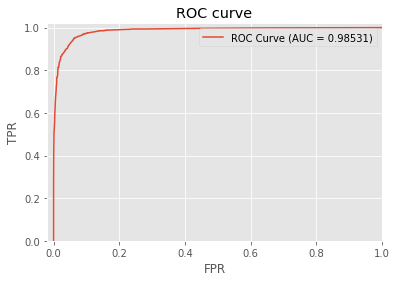

In [13]:
plt.style.use('ggplot')
plt.plot(results['roc_curve']['fpr'],
         results['roc_curve']['tpr'],
         label='ROC Curve (AUC = %0.5f)' %results['auc'])

plt.xlim([-0.02, 1.0])
plt.ylim([0., 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()
plt.show()

**Question 2:** Use three different centrality algorithms to identify managers at Enron.
    Evaluate the precision@10 of the algorithms, i.e. how many managers attained the top-10 highest ranks (30pt). Draw 
    the network and visualize one of the centrality measures (10pt)
    

In [14]:
# Create the graph out of the emails (from lecture)

enron_data_set_path = "maildir"

def get_links_from_email(path):
    email_re = re.compile(r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)")
    to_list = []
    from_list = []
    for line in open(path, "r", encoding='utf8', errors='ignore').readlines():
        line = line.strip().lower()
        if line.startswith("to:"):
            to_list = email_re.findall(line)
        if line.startswith("from:"):
            from_list = email_re.findall(line)
    links = set()
    if len(from_list) > 0 and len(to_list) >0:
        for e1 in from_list:
            for e2 in to_list:
                links.add((e1,e2))
    return links          

links = set()
files_list = [p for p in glob(f"{enron_data_set_path}/*/*/*") if "/inbox/" in p or "/sent/" in p]
print("Found %s files" % len(files_list))
for i in tqdm(range(len(files_list))):
    p = files_list[i]              
    if os.path.isfile(p):
        try:
            links |= get_links_from_email(p)
        except:
            continue

g = nx.DiGraph()
g.add_edges_from(links)

Found 99279 files


In [15]:
# Find the actual positions of the employees from the file "roles.txt"

def get_positions_dict(file='roles.txt'):
    with open(file, "r") as f:
        lines = f.readlines()
    nld = {}
    for l in lines:
        try:
            spl = l.split()
            em = spl[0]+"@enron.com"
            nld[em] = {}
            nld[em]["name"] = spl[1] + " " + spl[2]
            nld[em]["job"] = spl[3]
        except:
            pass
    return nld

positions_dict = get_positions_dict()
positions_dict

{'albert.meyers@enron.com': {'name': 'Albert Meyers', 'job': 'Employee'},
 'a..martin@enron.com': {'name': 'Thomas Martin', 'job': 'Vice'},
 'andrea.ring@enron.com': {'name': 'Andrea Ring', 'job': 'N/A'},
 'andrew.lewis@enron.com': {'name': 'Andrew Lewis', 'job': 'Director'},
 'andy.zipper@enron.com': {'name': 'Andy Zipper', 'job': 'Vice'},
 'a..shankman@enron.com': {'name': 'Jeffrey Shankman', 'job': 'President'},
 'barry.tycholiz@enron.com': {'name': 'Barry Tycholiz', 'job': 'Vice'},
 'benjamin.rogers@enron.com': {'name': 'Benjamin Rogers', 'job': 'Employee'},
 'bill.rapp@enron.com': {'name': 'Bill Rapp', 'job': 'N/A'},
 'bill.williams@enron.com': {},
 'brad.mckay@enron.com': {'name': 'Bradley Mckay', 'job': 'Employee'},
 'brenda.whitehead@enron.com': {},
 'b..sanders@enron.com': {'name': 'Richard Sanders', 'job': 'Vice'},
 'cara.semperger@enron.com': {'name': 'Cara Semperger', 'job': 'Employee'},
 'c..giron@enron.com': {'name': 'Daron Giron', 'job': 'Employee'},
 'charles.weldon@enr

In [6]:
# Compute three different centrality measures

d = nx.degree_centrality(g)
degree_centrality = sorted(dict(d).items(), key=operator.itemgetter(1), reverse=True)

d = nx.pagerank(g)
pagerank_centrality = sorted(dict(d).items(), key=operator.itemgetter(1), reverse=True)

d = nx.closeness_centrality(g)
closeness_centrality = sorted(dict(d).items(), key=operator.itemgetter(1), reverse=True)

In [7]:
# Turn the centrality list to top-10 dataframe with the positions of the employees

def centrality_to_top_10(centrality_list):
    df = pd.DataFrame(centrality_list[:10], columns=['email', 'centrality_score'])
    positions = []
    for i in range(10):
        if df['email'][i] in positions_dict:
            try:
                positions.append(positions_dict[df['email'][i]]['job'])
            except:
                positions.append("N/A")
        else:
            positions.append("N/A")
    df['position'] = positions
#     print(positions)
    return df   

df = centrality_to_top_10(closeness_centrality) 
df

,email,centrality_score,position
0,john.lavorato@enron.com,0.079416,CEO
1,tim.belden@enron.com,0.079404,N/A
2,kenneth.lay@enron.com,0.079388,CEO
3,greg.whalley@enron.com,0.078275,President
4,sally.beck@enron.com,0.076271,Employee
5,louise.kitchen@enron.com,0.076049,President
6,k..allen@enron.com,0.074550,Manager
7,rick.buy@enron.com,0.073342,Manager
8,scott.neal@enron.com,0.073290,Vice
9,john.arnold@enron.com,0.071933,Vice


In [8]:
magement_positions = ['CEO', 'President', 'Vice', 'Manager']

**I decided to ignore employees with unknown position for the evaluation**

In [11]:
# Compute precision@10
def compute_precision_10(employees):
    df = centrality_to_top_10(employees) 
    num_known_positions = df[df['position']!='N/A'].shape[0]
    num_management_positions = df[df['position'].isin(magement_positions)].shape[0]
    prec = num_management_positions/num_known_positions
    return prec

print('precision@10 by degree centrality: '+str(compute_precision_10(degree_centrality)))
print('precision@10 by pagerank centrality: '+str(compute_precision_10(pagerank_centrality)))
print('precision@10 by closeness centrality: '+str(compute_precision_10(closeness_centrality)))

precision@10 by degree centrality: 0.5
precision@10 by pagerank centrality: 0.8333333333333334
precision@10 by closeness centrality: 0.8888888888888888


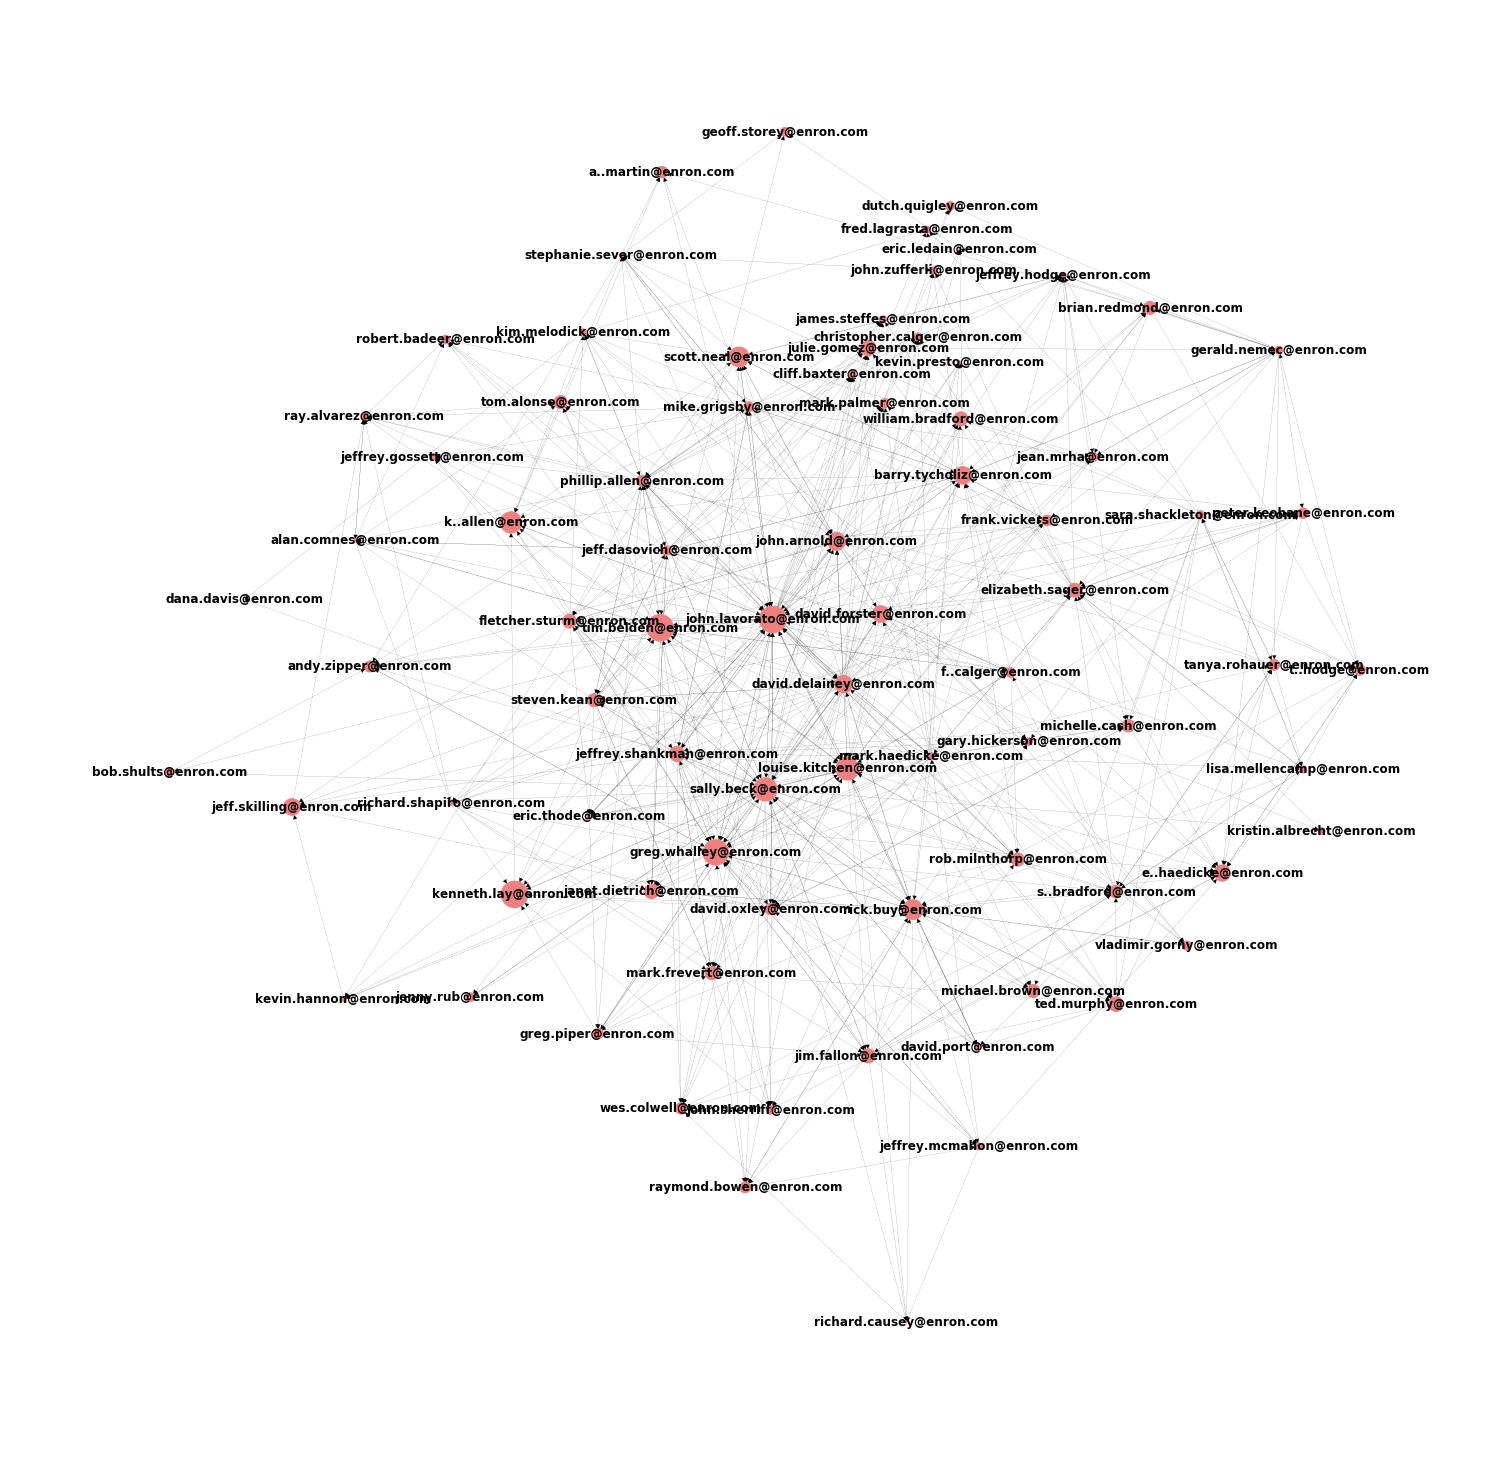

In [57]:
# Graph visualization with mapping of node size to centrality

# I used the closeness centrality measure for the visualization

scaled_centrality = MinMaxScaler().fit_transform(np.array([degree for email, degree in closeness_centrality[:80]]).reshape(-1, 1))
centralities = []
for i in range(len(scaled_centrality)):
    centralities.append((closeness_centrality[i][0], scaled_centrality[i][0]))
d = dict(centralities)
l = [n for n,degree in d.items()]

h = g.subgraph(l)
plt.figure(3, figsize=(20,20))
nx.draw_kamada_kawai(h, node_size=[(d[node])*700 for node in h.nodes()], with_labels=True,
                    width=0.1, font_size=12, font_weight=600, node_color='lightcoral')